# SisFall

In [6]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import CuDNNLSTM, CuDNNGRU, Dropout
from keras.optimizers import Adam, SGD
import math
import random
import numpy as np
import os

import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from keras.utils import to_categorical

# Import own methods

import data_generator as dg
import ml_utils as mlu


Checking if GPU are avaliable

In [2]:
from tensorflow.python.client import device_lib
from keras import backend as K

print("Process Units detected by tensorflow: ")
print(device_lib.list_local_devices())


print("GPUs used by keras:")
K.tensorflow_backend._get_available_gpus()

Process Units detected by tensorflow: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11819840636434844136
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2117344850007441314
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7082544040145135436
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10591970919
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14475087295096292453
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
GPUs used by keras:


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
dataTrWinValues, dataTrWinLabel, dataTestWinValues, dataTestWinLabel, dataWinOrganization = \
dg.loadDataSetInBlocks('../', nTestUsers=8, windowSize=256, stride=128)

Loading data...

Divided (train - test) found. Loading...

Data loaded correctly

Estructuring data in blocks...

Data generated correctly


In [4]:
unique, counts = np.unique(dataTrWinLabel, return_counts=True)

dict_counts = dict(zip(unique,counts))
print(dict_counts)

N_bkg = dict_counts[0]
N_alert = dict_counts[1]
N_fall = dict_counts[2]

print(N_bkg, N_alert, N_fall)

w_bkg = 1
w_alert = N_bkg / N_alert 
w_fall = N_bkg / N_fall

target_weights = [w_bkg,w_alert,w_fall]
print(target_weights)


{0: 89631, 1: 1031, 2: 3380}
89631 1031 3380
[1, 86.93598448108632, 26.518047337278105]


In [5]:
###############################################################
#
# The loss function implemented doesn't work with int targets
from keras.utils import to_categorical

dataTrWinLabelOneHot = to_categorical(dataTrWinLabel)
dataTestWinLabelOneHot = to_categorical(dataTestWinLabel)

###############################################################

## Paper model

In [9]:
model_paper_model_100ep = Sequential()

model_paper_model_100ep.add(Dense(32, batch_input_shape = (None, 256, 3)))

model_paper_model_100ep.add(BatchNormalization())

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(CuDNNLSTM((32), return_sequences=True))

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(CuDNNLSTM((32)))

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(Dense(3,activation='softmax'))

model_paper_model_100ep.compile(optimizer='adam', loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_paper_model_100ep.summary()

history_paper_model_100ep = model_paper_model_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=100, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

results_paper_model_100ep = model_paper_model_100ep.predict(dataTestWinValues[:,:,:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256, 32)           128       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 32)           128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 32)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 256, 32)           8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 32)           0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
__________

KeyboardInterrupt: 

In [9]:
history_paper_model_100ep.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

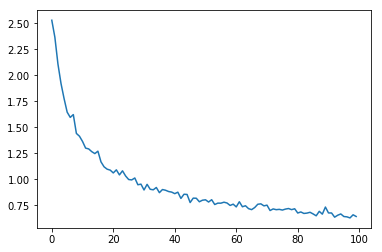

In [10]:
plt.plot(history_paper_model_100ep.history['loss'])
plt.show()

In [11]:
confusion_matrix_paper_model_100ep = confusion_matrix(dataTestWinLabel, np.argmax(results_paper_model_100ep, axis = 1))

Confusion matrix, without normalization
[[10085   494    40]
 [   18    67     3]
 [    9    24   296]]
Normalized confusion matrix
[[0.95 0.05 0.  ]
 [0.2  0.76 0.03]
 [0.03 0.07 0.9 ]]


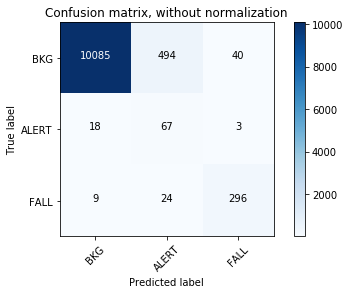

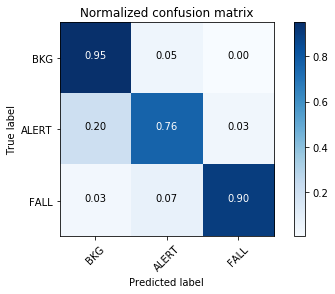

In [10]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(confusion_matrix_paper_model_100ep, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(confusion_matrix_paper_model_100ep, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [12]:
# Saving model
model_paper_model_100ep.save('paper_model_100ep.h5')

In [12]:
model_without_batch_norm_100ep = Sequential()

model_without_batch_norm_100ep.add(CuDNNGRU((32), batch_input_shape = (None, 256, 3)))

model_without_batch_norm_100ep.add(Dense(3,activation='softmax'))

model_without_batch_norm_100ep.compile(optimizer=Adam(lr=0.0008), loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_without_batch_norm_100ep.summary()

history_paper_model_100ep = model_without_batch_norm_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=100, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

results_paper_model_100ep = model_without_batch_norm_100ep.predict(dataTestWinValues[:,:,:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 32)                3552      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 3,651
Trainable params: 3,651
Non-trainable params: 0
_________________________________________________________________
Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 38s 404us/step - loss: 2.5136 - acc: 0.5923 - val_loss: 2.2657 - val_acc: 0.5930
Epoch 2/100
94042/94042 [==============================] - 39s 414us/step - loss: 1.9576 - acc: 0.6868 - val_loss: 2.1143 - val_acc: 0.6548
Epoch 3/100
94042/94042 [==============================] - 39s 413us/step - loss: 1.8048 - acc: 0.7413 - val_loss: 2.0783 - val_acc: 0.7061
Epoch 4/100
94042/94042 [==============================] - 38s 406

In [14]:
model_without_batch_norm_100ep.save('model_without_batch_norm_100ep.h5')

In [13]:
model_with_batch_norm_100ep = Sequential()

model_with_batch_norm_100ep.add(BatchNormalization(batch_input_shape = (None, 256, 3)))

model_with_batch_norm_100ep.add(CuDNNGRU((32)))

model_with_batch_norm_100ep.add(Dense(3,activation='softmax'))

model_with_batch_norm_100ep.compile(optimizer=Adam(lr=0.0008), loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_with_batch_norm_100ep.summary()

history_paper_model_100ep = model_with_batch_norm_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=100, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

results_paper_model_100ep = model_with_batch_norm_100ep.predict(dataTestWinValues[:,:,:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 256, 3)            12        
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 32)                3552      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 3,663
Trainable params: 3,657
Non-trainable params: 6
_________________________________________________________________
Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 42s 448us/step - loss: 2.5390 - acc: 0.5355 - val_loss: 2.6264 - val_acc: 0.7351
Epoch 2/100
94042/94042 [==============================] - 41s 438us/step - loss: 2.1759 - acc: 0.5973 - val_loss: 1.9283 - val_acc: 0.5978
Epoch 3/100
94042/94042 [==============================] - 42s 443us/step 

In [15]:
model_with_batch_norm_100ep.save('model_with_batch_norm_100ep.h5')

In [5]:
def RnnMmodel(w = 256, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.5, first_dense=True):
    
    if not (rnn_type == 'lstm' or rnn_type == 'gru'):
        print("rnn_type must be 'lstm' o  'gru'")
        return
    
    rnn_model = Sequential()
    if (first_dense):
        rnn_model.add(Dense(32, batch_input_shape = (None, w, 3)))
        rnn_model.add(BatchNormalization())
    else:
        rnn_model.add(BatchNormalization(batch_input_shape = (None, w, 3)))
    
    rnn_model.add(Dropout(drop_coeff_rnn))
    
    if two_rnn_layers:
        
        if rnn_type == 'lstm':
            rnn_model.add(CuDNNLSTM((32), return_sequences=True))
        elif rnn_type == 'gru':
            rnn_model.add(CuDNNGRU((32), return_sequences=True))
        
        if(drop_coeff_rnn != 0):
            rnn_model.add(Dropout(drop_coeff_rnn))
    
    if rnn_type == 'lstm':
        rnn_model.add(CuDNNLSTM((32)))
    elif rnn_type == 'gru':
        rnn_model.add(CuDNNGRU((32)))
    
    if(drop_coeff_dense !=0):
        rnn_model.add(Dropout(drop_coeff_dense))
    
    rnn_model.add(Dense(3,activation='softmax'))
    
    return rnn_model
    

In [6]:
def trainRNNModel(dataTrVal, dataTrLab, dataTestVal, dataTestLab, epochs = 100, lr=0.001, w = 256, stride = 128, batch_size = 32, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.5, first_dense=True):
    
    dataTrLabelOneHot = to_categorical(dataTrLab)
    dataTestLabelOneHot = to_categorical(dataTestLab)
    
    model = RnnMmodel(w, rnn_type, two_rnn_layers, drop_coeff_rnn, drop_coeff_dense, first_dense)
    
    model.summary()
    
    model_json = model.to_json()
    
    opt_adam = Adam(lr=lr)
    
    model.compile(optimizer=opt_adam, loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

    model_json = model.to_json()

    model_train_history = model.fit(dataTrVal, dataTrLabelOneHot, batch_size=batch_size, epochs=epochs, validation_data = (dataTestVal, dataTestLabelOneHot))

    model_prediction = model.predict(dataTestVal)

    model_confusion_matrix = confusion_matrix(dataTestLab, np.argmax(model_prediction, axis = 1))

    return model, model_train_history, model_confusion_matrix

In [250]:
results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, epochs = 125, lr=0.001, w = 256, stride = 128, batch_size = 96, rnn_type = 'lstm', two_rnn_layers=False, drop_coeff_rnn=0.2, drop_coeff_dense=0.2, first_dense=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 256, 3)            12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 3)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                4736      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________
Train on 94042 samples, validate on 22946 samples
Epoch 1/125
94042/94042 [==============================] - 16s 173us/step - loss: 2.5116 -

Epoch 52/125
94042/94042 [==============================] - 15s 162us/step - loss: 0.9750 - acc: 0.8863 - val_loss: 1.1099 - val_acc: 0.9090
Epoch 53/125
94042/94042 [==============================] - 16s 175us/step - loss: 0.8994 - acc: 0.9017 - val_loss: 1.1062 - val_acc: 0.9328
Epoch 54/125
94042/94042 [==============================] - 16s 165us/step - loss: 0.8523 - acc: 0.9194 - val_loss: 1.1849 - val_acc: 0.9508
Epoch 55/125
94042/94042 [==============================] - 15s 164us/step - loss: 0.9354 - acc: 0.9107 - val_loss: 1.0262 - val_acc: 0.9411
Epoch 56/125
94042/94042 [==============================] - 17s 178us/step - loss: 0.8740 - acc: 0.9269 - val_loss: 1.0719 - val_acc: 0.8946
Epoch 57/125
94042/94042 [==============================] - 16s 165us/step - loss: 0.8563 - acc: 0.9144 - val_loss: 1.0512 - val_acc: 0.8719
Epoch 58/125
94042/94042 [==============================] - 15s 159us/step - loss: 0.8710 - acc: 0.9064 - val_loss: 1.0385 - val_acc: 0.9245
Epoch 59/125


94042/94042 [==============================] - 15s 155us/step - loss: 0.5915 - acc: 0.9384 - val_loss: 0.9267 - val_acc: 0.9445
Epoch 111/125
94042/94042 [==============================] - 15s 156us/step - loss: 0.6193 - acc: 0.9339 - val_loss: 0.9645 - val_acc: 0.9397
Epoch 112/125
94042/94042 [==============================] - 15s 157us/step - loss: 0.6675 - acc: 0.9288 - val_loss: 1.1903 - val_acc: 0.9499
Epoch 113/125
94042/94042 [==============================] - 15s 157us/step - loss: 0.6174 - acc: 0.9366 - val_loss: 1.1444 - val_acc: 0.9247
Epoch 114/125
94042/94042 [==============================] - 15s 156us/step - loss: 0.6699 - acc: 0.9303 - val_loss: 0.9488 - val_acc: 0.9429
Epoch 115/125
94042/94042 [==============================] - 16s 170us/step - loss: 0.6229 - acc: 0.9281 - val_loss: 0.9696 - val_acc: 0.9366
Epoch 116/125
94042/94042 [==============================] - 17s 178us/step - loss: 0.6230 - acc: 0.9353 - val_loss: 1.1113 - val_acc: 0.9480
Epoch 117/125
94042/

In [251]:
#plt.plot(results[1].history['val_acc'])
#plt.show()
#type(results[1].history['val_acc'])
#type(results[2])
results[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 256, 3)            12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 3)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                4736      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________


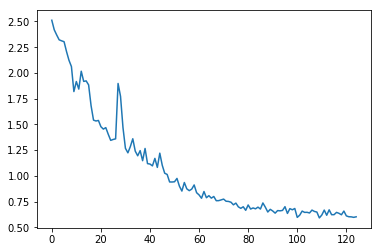

In [254]:
trained_model = results[0]
train_info = results[1].history
eval_info = results[2]
model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'test_subjects=8, w=256, stride=128'}
plt.plot(results[1].history['loss'])
plt.show()

Confusion matrix, without normalization
[[20752  1118    97]
 [   45   280    17]
 [    7    36   594]]
Normalized confusion matrix
[[0.94 0.05 0.  ]
 [0.13 0.82 0.05]
 [0.01 0.06 0.93]]


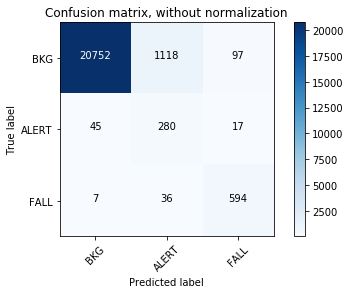

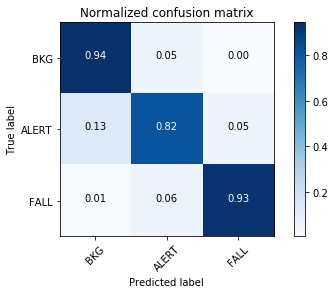

In [253]:
model_confusion_matrix = results[2]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
import pandas as pd

model_set_name = 'researchset_c_2'
w_list = [256]
stride_list = [128]
rnntype_list = ['lstm', 'gru'] #['lstm', 'gru']
lr_list = [0.0015, 0.001, 0.0005] #[0.005, 0.001, 0.0005]
batchsize_list = [32, 64]
drop_coeff_rnn_list = [0.2]
drop_coeff_dense_list = [0.35]
# Construction of data_frame with | model_id | param_1 | ... | param_n | as columns

info_list = list()
model_id = 1
for w in w_list:
    for stride in stride_list:
        for rnntype in rnntype_list:
            for lr in lr_list:
                for batchsize in batchsize_list:
                    for drop_rnn in drop_coeff_rnn_list:
                        for drop_dense in drop_coeff_dense_list:
                            #if (drop_rnn == 0.2 and drop_dense == 0):
                            #    print('dropout_rnn == 0.2 and dropout_dense == 0 jumped'.format())
                            #    continue
                            print([model_id, w, stride, rnntype, lr, batchsize, drop_rnn, drop_dense, False, False])
                            info_list.append([model_id, w, stride, rnntype, lr, batchsize, drop_rnn, drop_dense, False, False])
                            model_id += 1

info_dataframe = pd.DataFrame(info_list, columns = ['model_id', 'w', 'stride', 'rnn_type', 'lr', 'batch_size', 'rnn_dropout', 'dense_dropout', 'two_rnn_layers', 'first_dense'])

## Saving the dataframe
#info_dataframe.to_csv(model_set_name + '_research_summary.csv', index=False)

model_id = 1
for w in w_list:
    for stride in stride_list:
        for rnntype in rnntype_list:
            for lr in lr_list:
                for batchsize in batchsize_list:
                    for drop_rnn in drop_coeff_rnn_list:
                        for drop_dense in drop_coeff_dense_list:
                            #if (drop_rnn == 0.2 and drop_dense == 0):
                            #    print('dropout_rnn == 0.2 and dropout_dense == 0 jumped'.format())
                            #    continue
                            print('\n=======================\nModel no. {}'.format(model_id))
                            if(model_id == 8 or model_id == 9):
                                results = trainRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, epochs = 100, lr=lr, w = w, stride = stride, batch_size = batchsize, rnn_type = rnntype, two_rnn_layers=False, drop_coeff_rnn=drop_rnn, drop_coeff_dense=drop_dense, first_dense=False)
                                train_info = results[1].history
                                eval_info = results[2]
                                model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'n_test_subjects=8, w=256, stride=128'}
                                # Saving both model and performance_info
                                np.save(model_set_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
                                results[0].save(model_set_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
                            model_id += 1

[1, 256, 128, 'lstm', 0.0015, 32, 0.2, 0.35, False, False]
[2, 256, 128, 'lstm', 0.0015, 64, 0.2, 0.35, False, False]
[3, 256, 128, 'lstm', 0.001, 32, 0.2, 0.35, False, False]
[4, 256, 128, 'lstm', 0.001, 64, 0.2, 0.35, False, False]
[5, 256, 128, 'lstm', 0.0005, 32, 0.2, 0.35, False, False]
[6, 256, 128, 'lstm', 0.0005, 64, 0.2, 0.35, False, False]
[7, 256, 128, 'gru', 0.0015, 32, 0.2, 0.35, False, False]
[8, 256, 128, 'gru', 0.0015, 64, 0.2, 0.35, False, False]
[9, 256, 128, 'gru', 0.001, 32, 0.2, 0.35, False, False]
[10, 256, 128, 'gru', 0.001, 64, 0.2, 0.35, False, False]
[11, 256, 128, 'gru', 0.0005, 32, 0.2, 0.35, False, False]
[12, 256, 128, 'gru', 0.0005, 64, 0.2, 0.35, False, False]

Model no. 1

Model no. 2

Model no. 3

Model no. 4

Model no. 5

Model no. 6

Model no. 7

Model no. 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 256, 3)            12      

Epoch 45/100
94042/94042 [==============================] - 22s 232us/step - loss: 0.5963 - acc: 0.9327 - val_loss: 0.9684 - val_acc: 0.9454
Epoch 46/100
94042/94042 [==============================] - 22s 231us/step - loss: 0.5822 - acc: 0.9318 - val_loss: 0.9477 - val_acc: 0.9291
Epoch 47/100
94042/94042 [==============================] - 22s 232us/step - loss: 0.6082 - acc: 0.9282 - val_loss: 0.9012 - val_acc: 0.9199
Epoch 48/100
94042/94042 [==============================] - 22s 231us/step - loss: 0.5917 - acc: 0.9290 - val_loss: 1.0628 - val_acc: 0.9085
Epoch 49/100
94042/94042 [==============================] - 22s 232us/step - loss: 0.6209 - acc: 0.9315 - val_loss: 0.9963 - val_acc: 0.8430
Epoch 50/100
94042/94042 [==============================] - 22s 231us/step - loss: 0.5902 - acc: 0.9271 - val_loss: 1.0151 - val_acc: 0.9312
Epoch 51/100
94042/94042 [==============================] - 22s 233us/step - loss: 0.5657 - acc: 0.9299 - val_loss: 1.0185 - val_acc: 0.9282
Epoch 52/100


Train on 94042 samples, validate on 22946 samples
Epoch 1/100
94042/94042 [==============================] - 43s 460us/step - loss: 2.6056 - acc: 0.5136 - val_loss: 2.4934 - val_acc: 0.6804
Epoch 2/100
94042/94042 [==============================] - 42s 449us/step - loss: 2.2452 - acc: 0.5782 - val_loss: 1.9345 - val_acc: 0.5736
Epoch 3/100
94042/94042 [==============================] - 42s 452us/step - loss: 1.7308 - acc: 0.6663 - val_loss: 1.5558 - val_acc: 0.7679
Epoch 4/100
94042/94042 [==============================] - 42s 449us/step - loss: 1.4352 - acc: 0.7513 - val_loss: 1.3377 - val_acc: 0.7767
Epoch 5/100
94042/94042 [==============================] - 42s 449us/step - loss: 1.3499 - acc: 0.7725 - val_loss: 1.2596 - val_acc: 0.8809
Epoch 6/100
94042/94042 [==============================] - 42s 451us/step - loss: 1.2024 - acc: 0.8220 - val_loss: 1.3823 - val_acc: 0.9369
Epoch 7/100
94042/94042 [==============================] - 42s 451us/step - loss: 1.1565 - acc: 0.8609 - val_l

Epoch 59/100
94042/94042 [==============================] - 42s 450us/step - loss: 0.5897 - acc: 0.9325 - val_loss: 1.3075 - val_acc: 0.9480
Epoch 60/100
94042/94042 [==============================] - 42s 450us/step - loss: 0.7243 - acc: 0.9265 - val_loss: 1.1439 - val_acc: 0.9505
Epoch 61/100
94042/94042 [==============================] - 42s 449us/step - loss: 0.7063 - acc: 0.9260 - val_loss: 0.9793 - val_acc: 0.9432
Epoch 62/100
94042/94042 [==============================] - 42s 447us/step - loss: 0.6160 - acc: 0.9333 - val_loss: 1.0089 - val_acc: 0.9305
Epoch 63/100
94042/94042 [==============================] - 42s 449us/step - loss: 0.5989 - acc: 0.9318 - val_loss: 1.1831 - val_acc: 0.9463
Epoch 64/100
94042/94042 [==============================] - 42s 449us/step - loss: 0.6024 - acc: 0.9314 - val_loss: 1.1436 - val_acc: 0.9441
Epoch 65/100
94042/94042 [==============================] - 42s 451us/step - loss: 0.5607 - acc: 0.9335 - val_loss: 1.2896 - val_acc: 0.9491
Epoch 66/100


## Analysis of results

In [6]:
def plot_confusion_matrix_v2(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm = cm.astype('int')
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')

In [3]:
import pandas as pd
from keras.models import load_model

research_set_folder = 'researchset4'

### Model table

In [4]:
research_set_table = pd.read_csv(research_set_folder + '/' + research_set_folder + '_research_summary.csv')
research_set_table

,model_id,w,stride,rnn_type,lr,batch_size,rnn_dropout,dense_dropout,two_rnn_layers,first_dense
0,1,256,128,lstm,0.001,32,0.20,0.2,False,False
1,2,256,128,lstm,0.001,32,0.35,0.0,False,False
2,3,256,128,lstm,0.001,32,0.35,0.2,False,False
3,4,256,128,lstm,0.001,64,0.20,0.2,False,False
4,5,256,128,lstm,0.001,64,0.35,0.0,False,False
5,6,256,128,lstm,0.001,64,0.35,0.2,False,False
6,7,256,128,gru,0.001,32,0.20,0.2,False,False
7,8,256,128,gru,0.001,32,0.35,0.0,False,False
8,9,256,128,gru,0.001,32,0.35,0.2,False,False
9,10,256,128,gru,0.001,64,0.20,0.2,False,False


### Independent model results

#### Show results

In [7]:
ex_model_info = np.load(research_set_folder + '/' + research_set_folder +  '_model_id_2_info.npy')
ex_model_info = ex_model_info[()]
ex_model_info['optional_data']

'n_test_subjects=8, w=256, stride=128'

* #### Train history

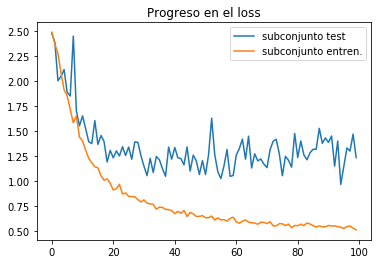

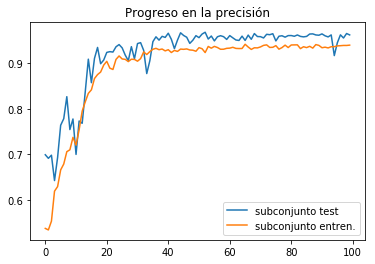

In [8]:
train_history = ex_model_info['train_history']
plt.close("all")
plt.plot(list(range(len(train_history['val_loss']))), train_history['val_loss'], label = 'subconjunto test')
plt.plot(list(range(len(train_history['loss']))), train_history['loss'], label = 'subconjunto entren.' )
plt.title("Progreso en el loss")
plt.legend()

plt.show()

plt.plot(list(range(len(train_history['val_acc']))), train_history['val_acc'], label = 'subconjunto test')
plt.plot(list(range(len(train_history['acc']))), train_history['acc'], label = 'subconjunto entren.')
plt.title("Progreso en la precisión")
plt.legend()

plt.show()

* #### Evaluation with test set

Normalized confusion matrix
[[0.97 0.03 0.01]
 [0.2  0.76 0.05]
 [0.01 0.05 0.93]]
Confusion matrix, without normalization
[[21212   610   145]
 [   67   259    16]
 [    9    35   593]]


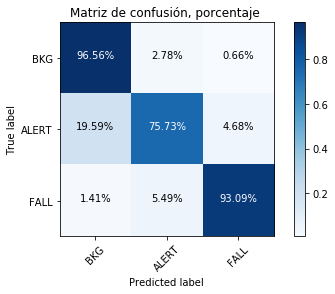

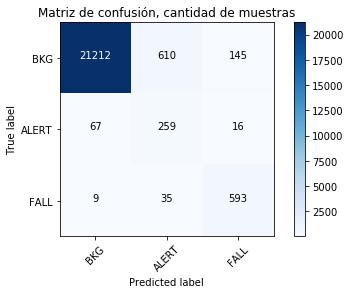

In [10]:
eval_results = ex_model_info['eval_results']
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(eval_results, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Matriz de confusión, porcentaje ')

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix_v2(eval_results, classes=['BKG', 'ALERT', 'FALL'],
                      title='Matriz de confusión, cantidad de muestras')

plt.show()

In [9]:
model = load_model('researchset5_model_id_4_fullmodel.h5', custom_objects={'loss': mlu.weighted_categorical_crossentropy(target_weights)})

In [11]:
eval_results = model.predict(dataTestWinValues[:,:,:3])


array([[9.9698442e-01, 2.7751208e-03, 2.4042414e-04],
       [9.9749494e-01, 2.1993746e-03, 3.0567677e-04],
       [9.9660206e-01, 3.2406547e-03, 1.5735431e-04],
       [9.9737263e-01, 2.4516031e-03, 1.7569038e-04],
       [9.9659401e-01, 3.0477790e-03, 3.5824525e-04],
       [9.9644560e-01, 3.1199846e-03, 4.3440139e-04],
       [9.9587458e-01, 3.5127904e-03, 6.1265583e-04]], dtype=float32)

In [18]:
np.shape(eval_results)
#eval_results[0:7]

(22946, 3)

Normalized confusion matrix
[[0.96 0.03 0.  ]
 [0.19 0.77 0.04]
 [0.02 0.06 0.91]]
Confusion matrix, without normalization
[[21129   740    98]
 [   66   263    13]
 [   14    41   582]]


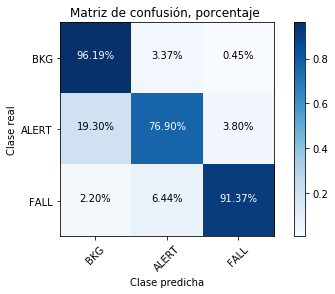

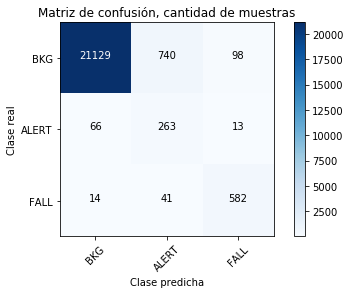

In [19]:
model_confusion_matrix = confusion_matrix(dataTestWinLabel, np.argmax(eval_results, axis = 1))


np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix_v2(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Matriz de confusión, porcentaje ')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix_v2(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'],
                      title='Matriz de confusión, cantidad de muestras')

plt.show()

Normalized confusion matrix
[[0.94 0.04 0.02]
 [0.05 0.93 0.02]
 [0.02 0.01 0.97]]
Confusion matrix, without normalization
[[20679   883   404]
 [   17   317     6]
 [   14     3   618]]


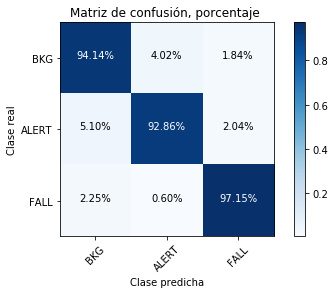

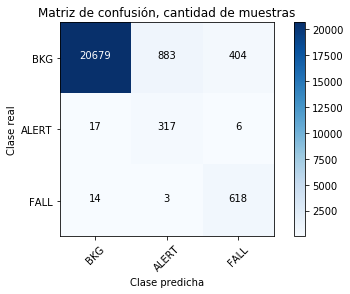

In [182]:
eval_results = np.array([[0.9414, 0.0402, 0.0184],[0.051, 0.9286, 0.0204],[0.0225, 0.006, 0.9716]])
eval_results_abs = eval_results*np.array([[21058+799+110],[57+270+15],[9+60+568]])
np.set_printoptions(precision=2)



# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix_v2(eval_results, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Matriz de confusión, porcentaje ')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix_v2(eval_results_abs, classes=['BKG', 'ALERT', 'FALL'],
                      title='Matriz de confusión, cantidad de muestras')

plt.show()

In [141]:
(eval_results/np.array([[21058+799+110],[57+270+15],[9+60+568]]))*100

array([[95.86,  3.64,  0.5 ],
       [16.67, 78.95,  4.39],
       [ 1.41,  9.42, 89.17]])

#### Load model

In [7]:
ex_model = load_model('researchset5_model_id_4_fullmodel.h5', custom_objects={'loss': mlu.weighted_categorical_crossentropy(target_weights)})
ex_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 256, 3)            12        
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 3)            0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                4736      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 4,847
Trainable params: 4,841
Non-trainable params: 6
_________________________________________________________________


In [9]:
ex_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
ex_model.save('researchset5_model_id_4_fullmodel_c.h5')

In [20]:
from keras.layers import LSTM, GRU, Dropout


model_paper_model_100ep = Sequential()

model_paper_model_100ep.add(Dense(32, batch_input_shape = (None, 256, 3)))

model_paper_model_100ep.add(BatchNormalization())

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(LSTM((32)))

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(Dense(3,activation='softmax'))

model_paper_model_100ep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_paper_model_100ep.summary()

# history_paper_model_100ep = model_paper_model_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=1, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

model_paper_model_100ep.save('test.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256, 32)           128       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 32)           128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 8,675
Trainable params: 8,611
Non-trainable params: 64
_________________________________________________________________


In [8]:
from keras.layers import LSTM, GRU

model_non_cudnn = Sequential()
model_non_cudnn.add(BatchNormalization(batch_input_shape = (None, 256, 3)))
model_non_cudnn.add(Dropout(0.35))
model_non_cudnn.add(LSTM((32)))
model_non_cudnn.add(Dropout(0.2))
model_non_cudnn.add(Dense(3,activation='softmax'))

model_non_cudnn.load_weights('researchset5_model_id_4_fullmodel.h5')

In [9]:
model_non_cudnn.summary()
model_non_cudnn.save('researchset5_model_id_4_fullmodel_non_cudnn.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 256, 3)            12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 3)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 4,719
Trainable params: 4,713
Non-trainable params: 6
_________________________________________________________________


In [10]:
model_prediction = model_non_cudnn.predict(dataTestWinValues[:,:,:3])
np.shape(model_prediction)

(22946, 3)

Confusion matrix, without normalization
[[20506  1392    69]
 [  160   166    16]
 [   45    52   540]]
Normalized confusion matrix
[[0.93 0.06 0.  ]
 [0.47 0.49 0.05]
 [0.07 0.08 0.85]]


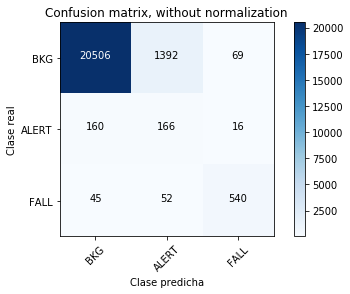

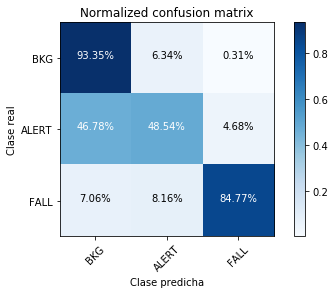

In [11]:
model_confusion_matrix = confusion_matrix(dataTestWinLabel, np.argmax(model_prediction, axis = 1))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix_v2(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix_v2(model_confusion_matrix, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [12]:
opt_adam = Adam(lr=0.008)
model_non_cudnn.compile(optimizer=opt_adam, loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_train_history = model_non_cudnn.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, batch_size=32, epochs=10, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

Train on 94042 samples, validate on 22946 samples
Epoch 1/10
94042/94042 [==============================] - 776s 8ms/step - loss: 1.8092 - acc: 0.7334 - val_loss: 1.9388 - val_acc: 0.7656
Epoch 2/10
94042/94042 [==============================] - 772s 8ms/step - loss: 2.3113 - acc: 0.6196 - val_loss: 2.3199 - val_acc: 0.8056
Epoch 3/10
94042/94042 [==============================] - 774s 8ms/step - loss: 2.1161 - acc: 0.6924 - val_loss: 2.0186 - val_acc: 0.7416
Epoch 4/10
94042/94042 [==============================] - 776s 8ms/step - loss: 2.2608 - acc: 0.6319 - val_loss: 2.5374 - val_acc: 0.5411
Epoch 5/10
94042/94042 [==============================] - 777s 8ms/step - loss: 2.5414 - acc: 0.5244 - val_loss: 2.5589 - val_acc: 0.5466
Epoch 6/10
94042/94042 [==============================] - 777s 8ms/step - loss: 2.4624 - acc: 0.5521 - val_loss: 2.3736 - val_acc: 0.6012
Epoch 7/10
94042/94042 [==============================] - 777s 8ms/step - loss: 2.4687 - acc: 0.5438 - val_loss: 2.3701 - 

In [13]:
model.save('researchset5_model_id_4_fullmodel_non_cudnn_trained.h5')

NameError: name 'model' is not defined